# Searching for specific star systems in BPASS using EvE

This jupyter notebook is an introduction to the EvE (Evolution Explorer) database that I created for myself to make searching for specific star systems in the BPASS stellar library easier and faster. 

The BPASS stellar library is a collection of >250,000 text files, each corresponding to a given star system simulated in BPASS. These textfiles contain a table that summarises the evolution of that star system, recording physical and observed properties (e.g. Luminosity, Temperature, Radii, but also UBVRI and other broad band magnitudes). 

So what is the point of EvE? Well say you're looking for the progenitor of a Luminous Red Nova, the explosion from a common envelope expulsion (or merger as a result of a common envelope), even if you have a good idea of the specific metallicity you want to look at (and therefore can focus on 1/13th of the models in the stellar library, because there are 13 metallicities in BPASS), you'll still need to paruse tens of thousands of files, looking through each of them to check which ones go through a common envelope, then looking through those for parameters that fit your pre-explosion images. It's not all that hard, but it takes a bit of time and if you look for transient progenitors regularly (or other star systems) you end up doing this over and over again. But there's no point! the models are pre-calculated, why don't we have some nice look up tables that summarise some key properties so we can discard all the models that we know we don't care about and then open up the ones we are interested in. 

In this tutorial we're going to be looking for an arbitrary (as in with properties I chose) super-luminous supernova. Once we've found our favourite potential progenitors we will explore their life by looking through their corresponding files in the BPASS stellar library. 

**To do this tutorial you will need:**
* **The BPASS stellar library**. It's about 8GB to download and 50GB (yes, of text files) once it is unzipped. You can find the data you need from a diet version of the BPASSv2.2.1 I created called the BPASS starter kit. I have put it on zenodo for your convenience. May the god of fast internet speeds be with you. [![DOI](https://zenodo.org/badge/DOI/10.5281/zenodo.7340797.svg)](https://doi.org/10.5281/zenodo.7340797)

* **The EvE data base [only download the .hdf5 file]**. I have put the alpha version on zenodo as well. The reason it is called the alpha version is that there are things that could do with being ironed out. Turns out that computationally exploring a bunch of tables is harder than it might seem when you're trying to summaries physical properties from simulations of physics that is.... challenging. For example **don't use the main sequen lifetime column wihtout caution**. It's hard to define the end of the Main Sequence when you're looking at models. Also note that you don't need the fortran code that is in this release - it's only there so that if someone finds a weird behaviour in the library they can check my code to find the inevitable silent bugs (or poor choices) that lie within it. 
[![DOI](https://zenodo.org/badge/DOI/10.5281/zenodo.7341382.svg)](https://doi.org/10.5281/zenodo.7341382)

* **My code hoki v1.7 and above**. The reason you need this current version is that it contains the Eve class that helps you not even have to rummage throuhg the EvE.hdf5 files itself. Off course you could just go through EvE with pandas but that's not what we're doing here. 

**If you have a question or a complain** start an issue on the [hoki](https://github.com/HeloiseS/hoki) github or send me an e-mail (hfstevance@gmail.com). I will do my best to help whilst I am still in science. If future me has left science, she might still be willing to help so it's worth giving the e-mail a try.  

Let's go! 

### Initial imports and EvE.hdf5 structure

We will need some standard python libraries. Pandas is my favourite way to deal with tables and that is why it's all over hoki and it is what the EvE.hdf5 file is made of. Let's talk about the EvE.hdf5 structure to help you understand what we'll be digging into.  

**[The `EvE.hdf5` file structure]**

In my EvE.hdf5 each group is one of BPASS metallicities. If you don't remember the BPASS metallicities and specifically what strings we like to use to name them, you can use the `hoki.constants` module to help you 


In [1]:
from hoki import constants as hc

In [3]:
hc.BPASS_METALLICITIES

['zem5',
 'zem4',
 'z001',
 'z002',
 'z003',
 'z004',
 'z006',
 'z008',
 'z010',
 'z014',
 'z020',
 'z030',
 'z040']

_**[! TIP !]:** in `hoki v1.7.2` I've added extra docs (amongst other things). You can then call `hc?` or `hoki.constants?` (depending on how you imported the module) and get a list of the constants in that module and a description._

So there are **13 groups in EvE.hdf5** each corresponding to a **BPASS metallicity**. Then each group contains the same tables (and we will look at those in just a second). **Each of these tables is a pandas dataframe contained within a dataset** of the hdf5 file. Now for those who work with hdf5 file you would be right to ask why not have sub-groups for each table and then each column in a dataset. And the answer to that is I like working with my pandas dataframes and I didn't see the point in undoing them and redoing them again. It's not the most data efficient thing but we're not dealing with large volumes here.

**[The `hoki.eve.Eve` class]**

In most cases you are only looking through one metallicity at a time. I've created a very basic `Eve` class in `hoki` that reads in each of the table for a given metallicity, mostly to minimise how much copy pasting I had to do. The nifty thing about having this as a stand alone object though is that it gives you a lot of nice flexibility to mess with the data to your hearts content, add your own tables, and then save that object so that your hard work is easy to load later on without having to retrace your steps. We'll see a few examples of how I use this and I'll show you how to pickle and load your Eve objects so that you can share your work with your future self and your colleagues. 

**[The imports]** 

Like I said we're going to use and abuse pandas, we'll need numpy and matplotlib, the hoki.eve module but also some of the tools in `hoki.load` which will come in useful futher into the tutorial. The style sheet is the same as the one in all the other [hoki tutorials](https://github.com/HeloiseS/hoki_tutorials) 

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from hoki.load import dummy_manual, dummy_to_dataframe, MODELS_PATH
from hoki.eve import Eve

plt.style.use('tuto.mplstyle')

Let's instanciate our `Eve` object. We'll need to specific a BPASS metallicity (must be contained in `hc.BPASS_METALLICITIES` above), the location of our hdf5 file, and if we want we can give a name to identify which project we are working on. This is an optional parameter (default None).

In [5]:
eve = Eve(met='z006',             # the metallicity string 
          eve_path='./EvE.hdf5',  # the location of the EvE.hdf5 file you downloaded
          name='BLA')             # an identifier for your project (optional)

So what tables have we made here? If you want a summary of the SCHEMA you can just summon the object you've instanciated

In [8]:
eve

<class 'hoki.eve.Eve'>
METALICITY: z006 

PROJECT NAME:	BLA

--------- SCHEMA -------

ID_TABLE
['filenames']

SUMMARY
['M1_ZAMS' 'M2_ZAMS' 'P_ZAMS' 'lifetime_MS' 'MT_bool' 'CEE_bool' 'AGE_end'
 'M1_end' 'M2_end' 'P_end' 'modelimf' 'mixedimf' 'type']

CEE
['TIMESTEP_start' 'AGE_start' 'M1_start' 'M2_start' 'P_start' 'LOGA_start'
 'TIMESTEP_end' 'AGE_end' 'M1_end' 'M2_end' 'P_end' 'LOGA_end'
 'avgDM1R_msolpyr' 'avgDM2R_msolpyr' 'avgDM1W_msolpyr' 'avgDM2W_msolpyr'
 'CASE']

MT
['TIMESTEP_start' 'AGE_start' 'M1_start' 'M2_start' 'P_start' 'LOGA_start'
 'TIMESTEP_end' 'AGE_end' 'M1_end' 'M2_end' 'P_end' 'LOGA_end'
 'avgDM1R_msolpyr' 'avgDM2R_msolpyr' 'avgDM1W_msolpyr' 'avgDM2W_msolpyr'
 'CASE']

DEATH
['timestep' 'age' 'log(R1)' 'log(T1)' 'log(L1)' 'M1' 'He_core1' 'CO_core1'
 'ONe_core1' 'Nan9' 'X' 'Y' 'C' 'N' 'O' 'Ne' 'MH1' 'MHe1' 'MC1' 'MN1'
 'MO1' 'MNe1' 'MMg1' 'MSi1' 'MFe1' 'envelope_binding_E' 'star_binding_E'
 'Mrem_weakSN' 'Mej_weakSN' 'Mrem_SN' 'Mej_SN' 'Mrem_superSN'
 'Mej_superSN

---
## The tables in EvE and key BPASS definitions 
### `ID_TABLE`


In [14]:
eve.ID_TABLE.tail()

filenames
MODEL_ID                                  
160756    NEWSINMODS/z006/sneplot-z006-1.1
160757      NEWSINMODS/z006/sneplot-z006-1
160758    NEWSINMODS/z006/sneplot-z006-0.9
160759    NEWSINMODS/z006/sneplot-z006-0.8
160760    NEWSINMODS/z006/sneplot-z006-0.6

As you can see above this relates the `MODEL_ID` and `filenames` properties. The `filenames` are the paths to a specific stellar system within the BPASS stellar library. These filenames are themselves unique identifiers of the models, but the problem is that if you're not working in FORTRAN using strings as unique identifiers is **VERY TIME CONSUMING**, e.g. if you want to check that a list of 300 models is (or is not) comprised in another list of 15,000 models. If all of those are strings it will take orders of magnitudes longer than if you use integers.

The `MODEL_ID` are these integers that are also unique identifiers of each model (unique across all 13 metallicities). **In general we use the `MODEL_ID` to do model selection within our pandas dataframes (see below), then when we want to open a specific model in the BPASS stellar library we go fetch the file name string to load it in.**

_**[? Q: WHAT MAKES A MODEL UNIQUE ?]** Models are calculated on a of Mass of the primary, mass ratio and period (for binaries), and metallicity. Within a given metallicity, each model as a unique combintation of (M1, M2, P) at age=0 (which may be ZAMS or the age at rejuvination)._

### The `SUMMARY`  table (and some needed BPASS-hoki concepts)

In [68]:
eve.SUMMARY.head()

M1_ZAMS  M2_ZAMS      P_ZAMS  lifetime_MS  MT_bool  CEE_bool  \
MODEL_ID                                                                 
139237       65.0      1.0  39090200.0    3321112.0        0         0   
139238       64.0      1.0  39389750.0    3355019.0        0         0   
139239       63.0      1.0  39696290.0    3390314.0        0         0   
139240       62.0      1.0  40010100.0    3406536.0        0         0   
139241       61.0      1.0  40331470.0    3444347.0        0         0   

            AGE_end    M1_end  M2_end          P_end  modelimf  mixedimf  type  
MODEL_ID                                                                        
139237    4002222.0  19.94971     1.0  0.3879680E+09  0.077866       0.0    -1  
139238    4033544.0  19.77729     1.0  0.3855040E+09  0.080755       0.0    -1  
139239    4065838.0  19.62953     1.0  0.3820573E+09  0.083800       0.0    -1  
139240    4099226.0  19.50653     1.0  0.3776276E+09  0.087011       0.0    -1  
139241    4133877.0  19.39798     1.0  0.3726069E+09  0.090400       0.0    -1

This table summarises information **from both the stellar library and the population synthesis**. EvE.hdf5 was created with the pop. synth from **the fiducial models** so if you want to use a different IMF you can't use EvE.hdf5 and have to do things the old fashioned way (which usually means contacting one of the BPASS team members). 

In `SUMMARY` you will find some basic info about the initial state of the models such as the mass of the primary and secondary at birth, their separation. **Note that single stars will have values in the M2_ZAMS and P_ZAMS** columns but they are obviously nonesensical placeholders. In a future version I should replace those with `np.NaN`, but there is a much **simpler way to know whether a model is a single star or a binary**. 

One of the columns in `SUMMARY` is `type`. This contains the BPASS type of this specific models, here are the options: 
* -1: Single star (pure single star from birth)
*  0: Merger has occured
*  1: Primary model (see below)
*  2: Secondary model (see below)
*  3: Secondary Single secondary star (after first star has died)
*  4: Quasi-homogenous evolution (only for low metallicities - see Eldridge et al. 2017 for details)

**[Primary models Vs Secondary models]**

In BPASS v2 the models are detailed... but only for one star at a time. The other star is evolved more similarly to what happens in a rapid code (again, check the instrument paper [Eldridge et al. 2017](https://ui.adsabs.harvard.edu/abs/2017PASA...34...58E/abstract)). **The primary models are those where the primary is evolved in detail, the secondary models are those where the secondary is evolved in detail AFTER THE FIRST STAR HAS DIED**. This is convenient for computing time purposes (especially because the models where calcualted a few years back) and also if you're looking at supernova kicks but that's a whole other tutorial. 

_**[! CAUTION !]** In the stellar evolution library the properties of star 1 are ALWAYS those of the star that is being evolved in detail. That means that in primary models M1 is the mass of the primary, but in the secondary models M1 is actually the mass of the secondary and M2 could be the mass of the Black Hole or Neutron Star left behind after the death of the primary_

Other properties in the `SUMMARY` table relate to the final propeties of the model (`_end`). Those are copy pasted from the **last line** in the stellar model table. For massive stars it's indeed when the star dies. For white dwarves it's at the end of universe according to BPASS or when the model crashes. 

**[`modelimf` and `mixedimf`]**

The other crucial properties provided in this table are the **pop. synth** properties that tell you **how many of each system you expect to arise in a 1 Million Msol** population at the given metallicity. **Without these properties you can find a progenitor but have no idea how likely it is to occur in the Universe**. 

* `modelimf` -> how many such models occur (NO REJUVINATION) 
* `mixedimf` -> how many such models occur as a result of rejuvination

Note that in the BPASS input files (should you wish to look at them despite the fact they are not human readable) the `modelimf` is the TOTAL number (including `mixedimf`). This is not something you should _ever_ have to worry about, except maybe if you look into the entrails of `hoki` (espcially the CMD class) and see in the comments that the definition is ever so slightly different. I chose to separate the two in the table because of personal preference - in hinsight consistency might have been preferable but it is what it is. 

**[Mass transfer and Common Envelope Evolution]** 
If you are specifically looking for systems that underwent mass transfer (MT) or common envelope evolution (CEE) you can check the `MT_bool` and `CEE_bool` columns. A 0 means 'no' whilst a '1' means yes. But yes to what?

MT is programatically defined as the model having a period where there is mass loss through the roche lobe. CEE is defined as our star's radius exceeded the separation of the the binary. **Note that this is the CEE definition within the Cambridge STARS code for the onset of CEE so it is the only "correct" way to define it here even if you don't agree about the physics of this definition**

### The `CEE` and `MT` tables

This is a lovely transition to talk about our `CEE` and `MT` tables which summarise the periods of (stable) mass transfer and common envelope that our models undergo

In [18]:
eve.CEE.head()

TIMESTEP_start  AGE_start  M1_start  M2_start  P_start  LOGA_start  \
MODEL_ID                                                                       
139363                10   32696.60      2.95       0.0      0.0        -inf   
139365                10   35758.61      2.85       0.0      0.0        -inf   
139367                10   39374.49      2.75       0.0      0.0        -inf   
139369                10   43711.77      2.65       0.0      0.0        -inf   
139371                10   48974.07      2.55       0.0      0.0        -inf   

          TIMESTEP_end       AGE_end   M1_end  M2_end  P_end  LOGA_end  \
MODEL_ID                                                                 
139363            8350  9.742223e+10  0.74303     0.0    0.0      -inf   
139365            8260  9.746370e+10  0.71675     0.0    0.0      -inf   
139367            8190  9.751175e+10  0.69098     0.0    0.0      -inf   
139369            8130  9.756764e+10  0.66540     0.0    0.0      -inf   
139371            8090  9.763306e+10  0.64235     0.0    0.0      -inf   

          avgDM1R_msolpyr  avgDM2R_msolpyr  avgDM1W_msolpyr  avgDM2W_msolpyr  \
MODEL_ID                                                                       
139363                0.0              0.0              0.0              0.0   
139365                0.0              0.0              0.0              0.0   
139367                0.0              0.0              0.0              0.0   
139369                0.0              0.0              0.0              0.0   
139371                0.0              0.0              0.0              0.0   

         CASE  
MODEL_ID       
139363      A  
139365      A  
139367      A  
139369      A  
139371      A

In [16]:
eve.MT.head()

TIMESTEP_start     AGE_start  M1_start  M2_start   P_start  \
MODEL_ID                                                               
139478               600  1.640508e+03  299.3329      30.0  0.002748   
139478              4988  2.032127e+06  110.2153      30.0  0.002748   
139479               600  1.390236e+03  299.2373      60.0  0.002750   
139479              5000  1.980880e+06  113.6463      60.0  0.002750   
139480               500  7.313112e+02  298.6578      90.0  0.002750   

          LOGA_start  TIMESTEP_end     AGE_end     M1_end  M2_end     P_end  \
MODEL_ID                                                                      
139478      1.463748           800    23047.62  302.26110    30.0  0.002748   
139478      1.463748         11620  2448448.00   35.96710    30.0  0.002748   
139479      1.476344           900    46368.02  311.71300    60.0  0.002750   
139479      1.476344         12432  2435873.00   32.84911    60.0  0.002750   
139480      1.487931           900    37422.93  315.46130    90.0  0.002750   

          LOGA_end  avgDM1R_msolpyr  avgDM2R_msolpyr  avgDM1W_msolpyr  \
MODEL_ID                                                                
139478    1.463748        -0.085665              0.0         0.000026   
139478    1.463748        -0.085665              0.0         0.000026   
139479    1.476344        -0.100002              0.0         0.000026   
139479    1.476344        -0.100002              0.0         0.000026   
139480    1.487931        -0.100002              0.0         0.000026   

          avgDM2W_msolpyr CASE  
MODEL_ID                        
139478                0.0    A  
139478                0.0    B  
139479                0.0    A  
139479                0.0    B  
139480                0.0    A

As you can see they both contain the same columns, which for the most part have self explenatory names. Note that **the Periods are in units of log10(days)**. Also let's talk about `avgDM1R_msolpyr` and similarly named columns. 

`DM1R` is one of the columns in the stellar library tables, it is the mass loss through the roche lobe (or rather change in mass of the primary) in solar masses per second (not per 1.989 per second as shown in the BPASS manual). In these table I have taken the average of this mass loss and I report it in **Msol per year** not per second. This is because I think it's more important here to be consistent with the units observers (or other astronomers) expect rather than internal consistency. That being said if you see discrepancies between those average values and the numbers you see in the raw stellar library tables, check if it's not a conversion from seconds to years. 

`DM1W` is the mass loss to winds (of the primary). 

The other column names with 2 instead of one relate to the secondary. 

_**[! WARNING !]** I have tried to report whether the MT and CEE where Case A, B, or C. Similarly to how dificult and fuzzy, it is fuzzy to define these cases. They are there as first order approximations, if you want to do a good job you can check in the stellar evolution files and plot the mass of the cores (see below)_

### The `DEATH` table

This is easy: I just copy pasted the last row of each stellar model into this table. It seems useless until you spend ages looking at those last rows searching for explosive transient progenitors. Speaking of which, TIME TO GO LOOK FOR SUPER-LUMINOUS SUPERNOVAE!!!

## Use-case: Searching for a super-luminous supernova progenitor
We now have everything we need to start looking for matching models. But first let's define what we will be looking for today. 

**[Criteria to be matched]**

Let's look for the progenitor of a SLSN-I, meanign **no Hydrogen** in its envelope and **"no" helium**. We also have some information about its ejecta mass, and we can use other peoples models to estimate how much hydrogen can be "hidden" in our stellar envelope. 

* Massive star that can explode as a SN (we typically use CO core>1.38 Msol) 
* M ejecta >7 & <15
* No hydrogen at death  (using the stuff in https://arxiv.org/abs/1205.5349)
```
as little as 0.001 M of hydrogen with surface mass fraction as low
as 0.01 can produce a strong Hα line
```

In order to check all these conditions we need to look through the `eve.DEATH` table we mentioned above:


In [25]:
eve.DEATH.head()

timestep        age  log(R1)  log(T1)  log(L1)        M1  He_core1  \
MODEL_ID                                                                       
139237      7597.0  4002222.0 -0.00374  5.23904  5.90192  19.94971       0.0   
139238      7589.0  4033544.0 -0.01400  5.24344  5.89899  19.77729       0.0   
139239      7024.0  4065838.0 -0.24850  5.36890  5.93182  19.62953       0.0   
139240      7034.0  4099226.0 -0.25057  5.36898  5.92804  19.50653       0.0   
139241      7029.0  4133877.0 -0.25589  5.37104  5.92561  19.39798       0.0   

          CO_core1  ONe_core1  Nan9  ...        ?  modelimf  mixedimf  \
MODEL_ID                             ...                                
139237    19.57384    2.19591   0.0  ... -0.40303  0.077866       0.0   
139238    19.44443    2.21896   0.0  ... -0.40273  0.080755       0.0   
139239    17.23459    0.00024   0.0  ... -0.40231  0.083800       0.0   
139240    17.43372    0.00029   0.0  ... -0.40176  0.087011       0.0   
139241    17.04446    0.00032   0.0  ... -0.40114  0.090400       0.0   

               V-I         U         B         V         R         I         J  
MODEL_ID                                                                        
139237   -0.804765 -6.144496 -5.124525 -5.605848 -5.492907 -4.801082 -4.960115  
139238   -0.801254 -6.138891 -5.120062 -5.600776 -5.488411 -4.799521 -4.957952  
139239   -0.275980 -6.840992 -5.846130 -5.742734 -5.720248 -5.466754 -5.671823  
139240   -0.276187 -6.831222 -5.836364 -5.733389 -5.710909 -5.457203 -5.662486  
139241   -0.276718 -6.824322 -5.829474 -5.727585 -5.705117 -5.450867 -5.656701  

[5 rows x 59 columns]

As you can see there are a lot of columns, which correspond to those we can find in each stellar evolution model table in BPASSv2.2.1. You can check the BPASS manual to see a list, or you can use the `dummy_manual` dictionary, which pairs the column names (keys) as they are in the pandas dataframe with the definitions (values). 

In [5]:
dummy_manual

{'timestep': 'Time Step Number',
 'age': 'Age in years',
 'log(R1)': 'Log10(R/Rsun) of the primary',
 'log(T1)': 'Effective log10 temperature of the primary',
 'log(L1)': 'Log10(L/Lsun) of the primary',
 'M1': 'M/Msun of the primary',
 'He_core1': 'He core mass of the primary /Msun',
 'CO_core1': 'CO core mass of the primary /Msun',
 'ONe_core1': 'ONe core mass of the primary /Msun',
 'X': 'Surface mass fractions for X (hydrogen)',
 'Y': 'Surface mass fractions for Y (helium)',
 'C': 'Surface mass fractions for C (carbon)',
 'N': 'Surface mass fractions for N (nitrogem)',
 'O': 'Surface mass fractions for O (oxygen)',
 'Ne': 'Surface mass fractions for Ne (neon)',
 'MH1': 'Mass of Hydrogen in primary /Msun',
 'MHe1': 'Mass of Helium in primary /Msun',
 'MC1': 'Mass of Carbon in primary /Msun',
 'MN1': 'Mass of Nitrogen in primary /Msun',
 'MO1': 'Mass of Oxygen in primary /Msun',
 'MNe1': 'Mass of Neon in primary /Msun',
 'MMg1': 'Mass of Hydrogen in primary /Msun',
 'MSi1': 'Mass of S

**[Why "dummy"?]**

In the STARS code J.J. Eldridge wrote to output the data of the stellar library, the large array that contains the output is a variable called `dummy`, and it is this array that is contained in each stellar model text file. This place-holder name has been in the code for nearly 2 decades and for consistency is used in other bits of code like `TUI`  and now `hoki`. Evertime you see `dummy`, there is a relation to the `sneplot` files (i.e. the model files in the stellar library).

### Selecting our desired models

Each model has a unique ID `MODEL_ID` - it is unique across all 13 metallicities so it won't start at 0 (unless you're looking at the lowest metallicity: 10e-5).

Although you can just crop tables entierly I find the best approach is to store the sets of models IDs that correspond to specific properties of your search and then combine them and mask the full EvE tables. Let's see how this works below

## Finding CCSNe and Ibc (general)
We could start with the conditions stated above regarding the presence of hydrogen/helium and ejecta masses. That would be a faster way to crop down our sets of `MODEL_ID` but I want to do it in an order that will be more natural if you go looking for other types of transients. 

So first let's find the IDs of all the stars that will explode as CCSNe. We want massive stars (to be conservative we select everything above 7 Msol) and we want them to go through iron core collapse so we need the CO core to be >1.38 Msol at death and the ONe core >0.1 Msol at death. 

In [32]:
# models of massive stars (loose definition)
id_massive = set(eve.SUMMARY[eve.SUMMARY.M1_ZAMS>7].index)

**[Code break down]**
If you are not super familiar with pandas shenanigans here is a break down of the code above:

In [33]:
eve.SUMMARY.M1_ZAMS>7 # creates a **mask** (a series of booleans (False, True)) 

MODEL_ID
139237     True
139238     True
139239     True
139240     True
139241     True
          ...  
160756    False
160757    False
160758    False
160759    False
160760    False
Name: M1_ZAMS, Length: 21117, dtype: bool

In [34]:
eve.SUMMARY[eve.SUMMARY.M1_ZAMS>7] # selects all the rows of the SUMMARY tables where the mask says 'True'

M1_ZAMS  M2_ZAMS       P_ZAMS  lifetime_MS  MT_bool  CEE_bool  \
MODEL_ID                                                                  
139237       65.0      1.0   39090200.0    3321112.0        0         0   
139238       64.0      1.0   39389750.0    3355019.0        0         0   
139239       63.0      1.0   39696290.0    3390314.0        0         0   
139240       62.0      1.0   40010100.0    3406536.0        0         0   
139241       61.0      1.0   40331470.0    3444347.0        0         0   
...           ...      ...          ...          ...      ...       ...   
160727        9.5      1.0   98004320.0   24806290.0        0         0   
160728        9.0      1.0  100424500.0   27140890.0        0         0   
160729        8.5      1.0  103033400.0   30199880.0        0         0   
160730        8.0      1.0  105856800.0   33624640.0        0         0   
160731        7.5      1.0  108925700.0   38185990.0        0         0   

             AGE_end    M1_end  M2_end          P_end    modelimf  mixedimf  \
MODEL_ID                                                                      
139237     4002222.0  19.94971     1.0  0.3879680E+09    0.077866   0.00000   
139238     4033544.0  19.77729     1.0  0.3855040E+09    0.080755   0.00000   
139239     4065838.0  19.62953     1.0  0.3820573E+09    0.083800   0.00000   
139240     4099226.0  19.50653     1.0  0.3776276E+09    0.087011   0.00000   
139241     4133877.0  19.39798     1.0  0.3726069E+09    0.090400   0.00000   
...              ...       ...     ...            ...         ...       ...   
160727    29348150.0   9.15623     1.0  0.1047507E+09   41.799300  26.05064   
160728    32336710.0   8.69743     1.0  0.1067887E+09   98.579450  19.05651   
160729    35923690.0   8.24057     1.0  0.1088996E+09   56.428160  31.57097   
160730    40273060.0   7.78239     1.0  0.1111671E+09  103.634900  16.64214   
160731    45620450.0   7.32357     1.0  0.1135919E+09   96.289360  28.48787   

          type  
MODEL_ID        
139237      -1  
139238      -1  
139239      -1  
139240      -1  
139241      -1  
...        ...  
160727       3  
160728       3  
160729       3  
160730       3  
160731       3  

[11219 rows x 13 columns]

In [36]:
eve.SUMMARY[eve.SUMMARY.M1_ZAMS>7].index # returns the index of the selected rows

Int64Index([139237, 139238, 139239, 139240, 139241, 139242, 139243, 139244,
            139245, 139246,
            ...
            160722, 160723, 160724, 160725, 160726, 160727, 160728, 160729,
            160730, 160731],
           dtype='int64', name='MODEL_ID', length=11219)

In [37]:
set(eve.SUMMARY[eve.SUMMARY.M1_ZAMS>7].index) # returns a set 

{139237,
 139238,
 139239,
 139240,
 139241,
 139242,
 139243,
 139244,
 139245,
 139246,
 139247,
 139248,
 139249,
 139250,
 139251,
 139252,
 139253,
 139254,
 139255,
 139256,
 139257,
 139258,
 139259,
 139260,
 139261,
 139262,
 139263,
 139264,
 139265,
 139266,
 139267,
 139268,
 139269,
 139270,
 139271,
 139272,
 139273,
 139274,
 139275,
 139276,
 139277,
 139278,
 139279,
 139280,
 139281,
 139282,
 139283,
 139284,
 139285,
 139286,
 139287,
 139288,
 139289,
 139290,
 139291,
 139292,
 139293,
 139294,
 139295,
 139296,
 139297,
 139298,
 139299,
 139300,
 139301,
 139302,
 139303,
 139304,
 139305,
 139306,
 139307,
 139308,
 139309,
 139310,
 139311,
 139312,
 139313,
 139314,
 139315,
 139316,
 139317,
 139318,
 139319,
 139320,
 139321,
 139478,
 139479,
 139480,
 139481,
 139482,
 139483,
 139484,
 139485,
 139486,
 139487,
 139488,
 139489,
 139490,
 139491,
 139492,
 139493,
 139494,
 139495,
 139496,
 139497,
 139498,
 139499,
 139500,
 139501,
 139502,
 139503,
 

**SUMMARY table (only massive stars)**

if we now want to use our set to view a cropped version of the table we can do: 

In [38]:
eve.SUMMARY.loc[id_massive]

M1_ZAMS  M2_ZAMS       P_ZAMS  lifetime_MS  MT_bool  CEE_bool  \
MODEL_ID                                                                  
139237       65.0      1.0   39090200.0    3321112.0        0         0   
139238       64.0      1.0   39389750.0    3355019.0        0         0   
139239       63.0      1.0   39696290.0    3390314.0        0         0   
139240       62.0      1.0   40010100.0    3406536.0        0         0   
139241       61.0      1.0   40331470.0    3444347.0        0         0   
...           ...      ...          ...          ...      ...       ...   
160727        9.5      1.0   98004320.0   24806290.0        0         0   
160728        9.0      1.0  100424500.0   27140890.0        0         0   
160729        8.5      1.0  103033400.0   30199880.0        0         0   
160730        8.0      1.0  105856800.0   33624640.0        0         0   
160731        7.5      1.0  108925700.0   38185990.0        0         0   

             AGE_end    M1_end  M2_end          P_end    modelimf  mixedimf  \
MODEL_ID                                                                      
139237     4002222.0  19.94971     1.0  0.3879680E+09    0.077866   0.00000   
139238     4033544.0  19.77729     1.0  0.3855040E+09    0.080755   0.00000   
139239     4065838.0  19.62953     1.0  0.3820573E+09    0.083800   0.00000   
139240     4099226.0  19.50653     1.0  0.3776276E+09    0.087011   0.00000   
139241     4133877.0  19.39798     1.0  0.3726069E+09    0.090400   0.00000   
...              ...       ...     ...            ...         ...       ...   
160727    29348150.0   9.15623     1.0  0.1047507E+09   41.799300  26.05064   
160728    32336710.0   8.69743     1.0  0.1067887E+09   98.579450  19.05651   
160729    35923690.0   8.24057     1.0  0.1088996E+09   56.428160  31.57097   
160730    40273060.0   7.78239     1.0  0.1111671E+09  103.634900  16.64214   
160731    45620450.0   7.32357     1.0  0.1135919E+09   96.289360  28.48787   

          type  
MODEL_ID        
139237      -1  
139238      -1  
139239      -1  
139240      -1  
139241      -1  
...        ...  
160727       3  
160728       3  
160729       3  
160730       3  
160731       3  

[11219 rows x 13 columns]

Let's create a set of IDs for the models that do meet the explosion criteria at death. 

In [39]:
# models that can explode
id_does_explode = set(eve.DEATH[(eve.DEATH.CO_core1>1.38) & (eve.DEATH.ONe_core1>0.1)].index)

**The advantage of using sets is they have useful LOGIC** such as intersections, so we can easily select the IDs that belong to several sets without having to use tedious loops!

In [41]:
eve.SUMMARY.loc[id_massive.intersection(id_does_explode)]

M1_ZAMS  M2_ZAMS       P_ZAMS  lifetime_MS  MT_bool  CEE_bool  \
MODEL_ID                                                                  
139237       65.0      1.0   39090200.0    3321112.0        0         0   
139238       64.0      1.0   39389750.0    3355019.0        0         0   
139242       60.0      1.0   40660710.0    3483503.0        0         0   
139244       58.0      1.0   41344130.0    3545710.0        0         0   
139245       57.0      1.0   41699020.0    3567365.0        0         0   
...           ...      ...          ...          ...      ...       ...   
160727        9.5      1.0   98004320.0   24806290.0        0         0   
160728        9.0      1.0  100424500.0   27140890.0        0         0   
160729        8.5      1.0  103033400.0   30199880.0        0         0   
160730        8.0      1.0  105856800.0   33624640.0        0         0   
160731        7.5      1.0  108925700.0   38185990.0        0         0   

             AGE_end    M1_end  M2_end          P_end    modelimf  mixedimf  \
MODEL_ID                                                                      
139237     4002222.0  19.94971     1.0  0.3879680E+09    0.077866   0.00000   
139238     4033544.0  19.77729     1.0  0.3855040E+09    0.080755   0.00000   
139242     4169864.0  19.30547     1.0  0.3669499E+09    0.093981   0.00000   
139244     4246452.0  19.13785     1.0  0.3548877E+09    0.101774   0.00000   
139245     4287724.0  19.03751     1.0  0.3493766E+09    0.106020   0.00000   
...              ...       ...     ...            ...         ...       ...   
160727    29348150.0   9.15623     1.0  0.1047507E+09   41.799300  26.05064   
160728    32336710.0   8.69743     1.0  0.1067887E+09   98.579450  19.05651   
160729    35923690.0   8.24057     1.0  0.1088996E+09   56.428160  31.57097   
160730    40273060.0   7.78239     1.0  0.1111671E+09  103.634900  16.64214   
160731    45620450.0   7.32357     1.0  0.1135919E+09   96.289360  28.48787   

          type  
MODEL_ID        
139237      -1  
139238      -1  
139242      -1  
139244      -1  
139245      -1  
...        ...  
160727       3  
160728       3  
160729       3  
160730       3  
160731       3  

[7829 rows x 13 columns]

Now let's create more sets for our other conditions to find the **Ib/c CCSNe** and exclude the type II

In [42]:
# models that are hydrogen poor at death

# here I create the mask separately to make the code easier to read and the line not too long
mask_hpoor = (eve.DEATH.X<0.01) & (eve.DEATH.MH1<0.001) 
id_hpoor_at_death = set(eve.DEATH[mask_hpoor].index)

In [43]:
eve.SUMMARY.loc[id_massive.intersection(id_does_explode).intersection(id_hpoor_at_death)]

M1_ZAMS  M2_ZAMS        P_ZAMS  lifetime_MS  MT_bool  CEE_bool  \
MODEL_ID                                                                   
139264       38.0  1.00000  5.085194e+07    4740355.0        0         0   
139269       33.0  3.30000  5.270922e+07    5356467.0        0         0   
155699       15.0  1.99526  6.889769e-03   11693350.0        1         1   
155720       13.0  1.99526  6.889769e-03   14289210.0        1         1   
155764       10.0  1.99526  6.889769e-03   21717750.0        1         1   
...           ...      ...           ...          ...      ...       ...   
139259       43.0  1.00000  4.787552e+07    4314786.0        0         0   
139260       42.0  1.00000  4.842901e+07    4396715.0        0         0   
139261       41.0  1.00000  4.900216e+07    4483490.0        0         0   
139262       40.0  1.00000  4.959615e+07    4575031.0        0         0   
139263       39.0  1.00000  5.021227e+07    4672647.0        0         0   

             AGE_end    M1_end    M2_end          P_end  modelimf  mixedimf  \
MODEL_ID                                                                      
139264     5654447.0  15.43550  1.000000  0.2863389E+09  1.059677       0.0   
139269     6374174.0  13.65394  3.300000  0.2416464E+09  1.721225       0.0   
155699    15929940.0   2.71254  3.674444  0.1258471E-02  0.012344       0.0   
155720    18806370.0   2.55130  3.459257  0.1370293E-02  0.015927       0.0   
155764    27907000.0   1.78449  2.580905  0.2114332E-02  0.006067       0.0   
...              ...       ...       ...            ...       ...       ...   
139259     5151928.0  16.19231  1.000000  0.3135863E+09  0.792527       0.0   
139260     5241441.0  16.02714  1.000000  0.3088634E+09  0.837586       0.0   
139261     5335894.0  15.88997  1.000000  0.3030149E+09  0.886386       0.0   
139262     5435929.0  15.74946  1.000000  0.2971817E+09  0.939343       0.0   
139263     5541933.0  15.59117  1.000000  0.2918669E+09  0.996926       0.0   

          type  
MODEL_ID        
139264      -1  
139269      -1  
155699       2  
155720       2  
155764       2  
...        ...  
139259      -1  
139260      -1  
139261      -1  
139262      -1  
139263      -1  

[2677 rows x 13 columns]

## Matching ejecta mass and remnant mass

Here we want a neutron star so we will pick an remnant mass <3 Msol (take your pick). We also said earlier we want ejecta masses between 7 and 15 Msol. 

One thing we need to keep in mind is that BPASS models give you remnant masses and ejecta masses for 3 SN energies:
* 10e50 ergs (weakSN -> typically electron capture but can use it for partially failed SN)
* 10e51 ergs (you're average SN)
* 10e52 ergs (superSN -> useful for superluminous SNe like we have here). 

We'll also use a low Helium mass criteria at the end of the life of the star since we're looking for a SLSN-Ic:
See [Hachinger et al. 2012](https://arxiv.org/pdf/1201.1506.pdf) 

In [44]:
# If you have several conditions to write into your masks 
# not that you can go to the next line so the conditions sit on top of each other
# this makes the code easier to read.
id_ns_matchmej = (eve.DEATH[  (eve.DEATH.Mej_superSN>8)
                            & (eve.DEATH.Mej_superSN<13)
                            & (eve.DEATH.Mrem_superSN<3) # it's a neutron star
                            & (eve.DEATH.MHe1<0.3)       # not much helium left
                           ].index)

### Specific Angular momentum (gotta go fast to make a pulsar!)

Since we said we wanted a Superluminous supernova, we have a good idea that the compact remnant needs to be fast rotating. We can do a back of the envelope calculation to estimate the specific angular momentum j of our remnant and then select only the models that reach a certain (fist spinning) value. 

In [45]:
# first we need the radius of our stars in kilometers 
Rsun=696340    # radius of the sun in km

eve.DEATH['R1km']=(10**eve.DEATH['log(R1)'])*Rsun # in km

Note that here we are adding columns to our tables (in the above case `DEATH`) - **WE ARE NOT ADDING COLUMNS TO THE EVE.HDF5 DATABASE** only to the copy of the data that is contained in our `eve` object. Furthermore if you had another instance, say `eve2` that was created with the same data, these new columns would not appear in `eve2`, they are specific to this one object we are working with. This is very practical because you can mess with the data as much as you want, add, remove, change columns, to suit your science case. You can then (as we'll see later) save this work by pickling this `hoki.eve.Eve` instance. All of this without messing with the original data, or with other `hoki.eve.Eve` instances you might be running in the same notbok looking for some other object. 

Anyway, **let's look at the periods**... There is an issue with some of the period columns in that they are not numeric because some values of infinity has made their way in and had been recognised by pandas as strings, making the columns a mix of types (i.e. an object). I only noticed that after I'd compiled the .hdf5 file and left it - in future versions I can clean up the type issue. For now we need to use `pands.to_numeric` 

In [46]:
eve.DEATH.P_bin=pd.to_numeric(eve.DEATH.P_bin, errors='coerce')

Assuming that the rotational velocity of the star is synched with the period (which is okay if they've interacted), then we can calculate the rotational velocity in km/s

In [47]:
eve.DEATH['vrot_kms']=(2*np.pi*eve.DEATH.R1km.values)/(eve.DEATH.P_bin.values*365*24*3600)

<ipython-input-47-5a731fa27368>:1: RuntimeWarning: divide by zero encountered in true_divide
  eve.DEATH['vrot_kms']=(2*np.pi*eve.DEATH.R1km.values)/(eve.DEATH.P_bin.values*365*24*3600)


In [49]:
eve.DEATH.vrot_kms

MODEL_ID
139237    3.545347e-10
139238    3.484703e-10
139239    2.049114e-10
139240    2.063293e-10
139241    2.065636e-10
              ...     
160756             inf
160757             inf
160758             inf
160759             inf
160760             inf
Name: vrot_kms, Length: 21117, dtype: float64

In [51]:
# and we turn the rotational velocity into a specific AM
eve.DEATH['j_cm2s']=eve.DEATH['vrot_kms']*eve.DEATH.R1km * 1e10 #conversion to cm^2

In [55]:
# we also create and ID set that is the intersection of the sets we created above
# that is to make the code easier to read and shorter
id_best_sofar = id_massive.intersection(id_does_explode).intersection(id_hpoor_at_death).intersection(id_ns_matchmej)

In [54]:
eve.DEATH.loc[id_best_sofar].j_cm2s

MODEL_ID
159747    1.967440e+16
159748    1.419265e+16
159750    1.438781e+16
159751    9.292407e+15
159752    6.008772e+15
              ...     
158713    2.681758e+16
158714    1.591317e+16
158715    9.968024e+15
158716    6.323594e+15
158717    4.702891e+15
Name: j_cm2s, Length: 116, dtype: float64

Now we are going to use the properties of our imagined SLSN-I (it's actually using the values of SN 2017gci) to estimate a value of j that our remnants need to reach:

In [56]:
P=2.8*1e-3 #2.8ms
R=10*1e3*1e2 #10km is a good approx, in cm though 

In [62]:
j_17gci = (2/5) * (R**2) * 2*np.pi/P
j_17gci/1e14

8.975979010256552

so something around 1e15 and above, that's nice since (from the print out above) a lot of our models already have exceeding values and we're in the same ballpark in terms of orders of magnitude. **once again we create a set of MODEL_ID**

In [64]:
id_enough_rotation = set(eve.DEATH[eve.DEATH.j_cm2s>j_17gci].index)

In [65]:
id_best = id_best_sofar.intersection(id_enough_rotation)

In [66]:
eve.DEATH.loc[id_best]

timestep        age  log(R1)  log(T1)  log(L1)        M1  He_core1  \
MODEL_ID                                                                       
159747     10928.0  5618206.0 -0.22646  5.25413  5.51683  10.53407       0.0   
159748     10787.0  5488492.0 -0.21599  5.25719  5.55003  11.03129       0.0   
159750     10916.0  5429943.0 -0.21712  5.26568  5.58173  11.71055       0.0   
159751     11344.0  5427022.0 -0.20820  5.26706  5.60508  12.19142       0.0   
159752     11716.0  5427732.0 -0.19781  5.27005  5.63783  12.82921       0.0   
...            ...        ...      ...      ...      ...       ...       ...   
158713     10523.0  5433841.0 -0.22290  5.26152  5.55354  11.19408       0.0   
158714     10931.0  5430873.0 -0.21776  5.26448  5.57564  11.60518       0.0   
158715     11255.0  5427329.0 -0.21172  5.26760  5.60019  12.07276       0.0   
158716     11684.0  5427097.0 -0.20212  5.27051  5.63103  12.68744       0.0   
158717     12170.0  5430072.0 -0.15624  5.25498  5.66070  13.46907       0.0   

          CO_core1  ONe_core1  Nan9  ...       V-I         U         B  \
MODEL_ID                             ...                                 
159747    10.20924    1.47597   0.0  ... -0.426910 -5.593392 -4.584808   
159748    10.73932    1.44532   0.0  ... -0.610628 -5.452509 -4.432625   
159750    11.47110    1.63243   0.0  ... -0.599104 -5.543197 -4.523274   
159751    12.00032    1.86693   0.0  ... -0.652923 -5.547994 -4.528258   
159752    12.69262    2.04972   0.0  ... -0.671042 -5.611740 -4.592069   
...            ...        ...   ...  ...       ...       ...       ...   
158713    10.92697    1.51714   0.0  ... -0.548907 -5.522329 -4.502241   
158714    11.36546    1.66942   0.0  ... -0.590261 -5.536736 -4.516783   
158715    11.86242    1.74400   0.0  ... -0.629136 -5.559499 -4.539679   
158716    12.53888    1.98375   0.0  ... -0.677210 -5.588558 -4.568909   
158717    13.29260    2.06366   0.0  ... -0.376628 -6.022578 -5.018670   

                 V         R         I         J           R1km  vrot_kms  \
MODEL_ID                                                                    
159747   -4.654883 -4.602030 -4.227973 -4.405664  413391.310173  4.759268   
159748   -4.714235 -4.630044 -4.103607 -4.261867  423478.477630  3.351446   
159750   -4.792562 -4.710203 -4.193458 -4.351852  422378.052252  3.406383   
159751   -4.855170 -4.764397 -4.202248 -4.360003  431143.003804  2.155296   
159752   -4.938427 -4.844900 -4.267385 -4.424918  441581.980700  1.360738   
...            ...       ...       ...       ...            ...       ...   
158713   -4.717961 -4.643772 -4.169053 -4.328015  416793.889396  6.434254   
158714   -4.776623 -4.695680 -4.186361 -4.344857  421756.071356  3.773074   
158715   -4.841098 -4.754000 -4.211962 -4.370004  427662.670125  2.330815   
158716   -4.921893 -4.827437 -4.244683 -4.402140  437221.332166  1.446314   
158717   -5.029058 -4.985591 -4.652429 -4.837749  485938.538481  0.967795   

                j_cm2s  
MODEL_ID                
159747    1.967440e+16  
159748    1.419265e+16  
159750    1.438781e+16  
159751    9.292407e+15  
159752    6.008772e+15  
...                ...  
158713    2.681758e+16  
158714    1.591317e+16  
158715    9.968024e+15  
158716    6.323594e+15  
158717    4.702891e+15  

[116 rows x 62 columns]

And it looks like we have selected 116 models out of the >21k we could see in the original SUMMARY table (see below)

In [69]:
eve.SUMMARY.shape[0]

21117

## Let's explore the BPASS models!
Firstly we'll need to know where to look. The `MODELS_PATH` in `hoki.constants` contains the local path to the BPASS models  **if you have set it up**.
You can just temporarily create a MODELS_PATH variable with the path to the model library on your machine, or you can set it up permanently using the `hoki.constants.set_models_path` function (see its documentation for me info. For now you can see that by default it is set to the correct path on my own machine:

In [71]:
hc.MODELS_PATH

'/home/fste075/BPASS_hoki_dev/bpass-v2.2-newmodels/'

**[Reading in a model (sneplot) file]**

Within `hoki.load` there is a function called `dummy_to_dataframe` which will read in a model file into a dataframe with column names (the same ones we saw above with the `DEATH` table). 

Using this we can load in our matching models and plot them on an HR Diagram!

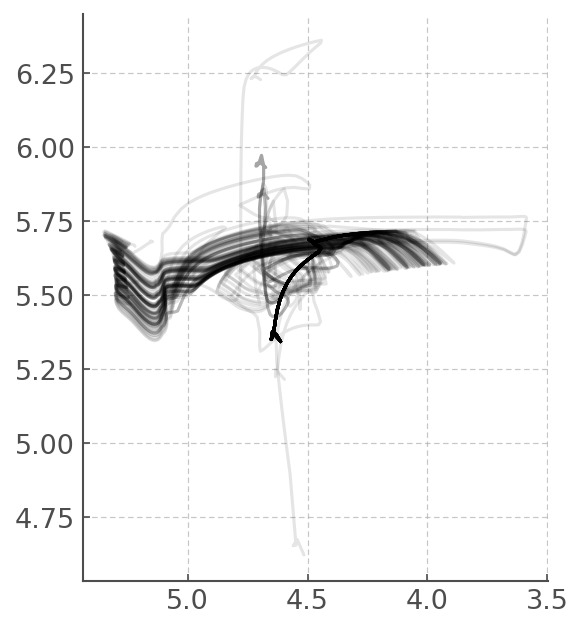

In [72]:
plt.figure(figsize=(4,5))

for _id in id_best: # id is a keyword in python, using _id avoids overwriting that keyword
    # As we saw much earlier, ID_TABLE is used to turn integer IDs 
    # into the filename strings we need. 
    _fname = eve.ID_TABLE.loc[_id].filenames 
    # Then we create a temporary dataframe containing the data for that one model
    # We can just add MODELS_PATH to the filename we just retrieved (make sure MODELS_PATH
    # ends with a / otherwise it won't be valid)
    _df = dummy_to_dataframe(MODELS_PATH+_fname)
    # finally we can plot our HRD data. Note that a low alpha is used 
    # so that we don't have an illegible plot. 
    plt.plot(_df['log(T1)'], _df['log(L1)'], color='k', alpha=0.1)
    
plt.gca().invert_xaxis()

nifty! but we're going to want do to a lot more than this. First of all plotting our stellar tracks in low alpha tells us where most of the models fall, but **not where most of the probability falls**. Each stellar model is more or less likely to occur (see the section on `modelimf`) and **we have to take that into account** if we want to do the stellar population synthesis bit correctly. 

First of all let's create a new `SUMMARY` table with our favourite models so we don't need to keep doing `.loc[id_best]` (this is another example of why handling this with an object is super flexible! we can add whatever attribute we want as we go through the analysis)

In [73]:
eve.SUMMARY_best = eve.SUMMARY.loc[id_best]

To get a quick idea of which models are best we can sort using `modelimf` 

In [75]:
eve.SUMMARY_best.sort_values('modelimf', ascending=False).head(10)

M1_ZAMS  M2_ZAMS    P_ZAMS  lifetime_MS  MT_bool  CEE_bool  \
MODEL_ID                                                               
141269       40.0      4.0  0.274287    4470888.0        1         1   
141270       40.0      8.0  0.274287    4470888.0        1         1   
141271       40.0     12.0  0.274287    4470888.0        1         1   
141260       40.0      4.0  0.173063    4470888.0        1         1   
141261       40.0      8.0  0.173063    4450443.0        1         1   
141262       40.0     12.0  0.173063    4470888.0        1         1   
141253       40.0     12.0  0.109195    4450443.0        1         1   
141251       40.0      4.0  0.109195    4450443.0        1         1   
141244       40.0     12.0  0.068898    4450443.0        1         1   
141226       40.0     12.0  0.027429    4470888.0        1         1   

            AGE_end    M1_end     M2_end          P_end  modelimf  mixedimf  \
MODEL_ID                                                                      
141269    5429815.0  13.79834   4.000171  0.1266157E+00  1.767013       0.0   
141270    5429342.0  13.39695   8.001817  0.1049087E+00  1.706822       0.0   
141271    5429529.0  13.58817  12.047250  0.1121516E+00  1.672568       0.0   
141260    5427357.0  12.95953   4.000201  0.7404644E-01  1.641982       0.0   
141261    5427467.0  12.75270   8.002334  0.6476529E-01  1.619376       0.0   
141262    5426833.0  12.88541  12.053630  0.7003154E-01  1.606297       0.0   
141253    5426638.0  12.25425  12.059850  0.4262797E-01  1.538057       0.0   
141251    5426505.0  12.30724   4.000213  0.4360660E-01  1.521252       0.0   
141244    5429384.0  11.76606  12.068530  0.2658655E-01  1.468233       0.0   
141226    5435845.0  11.06886  12.092340  0.1040865E-01  1.325502       0.0   

          type  
MODEL_ID        
141269       1  
141270       1  
141271       1  
141260       1  
141261       1  
141262       1  
141253       1  
141251       1  
141244       1  
141226       1

We can also get a broad view of the models we picked out with pandas tools like `describe()`. Although note all this is for preliminary data analysis, you wouldn't use those raw numbers to report in a paper, the progenitor isn't 43 Msol +/- 12. **DO NOT DO THIS PLEASE**. If you need me to explain in more details why **YOU CANNOT USE THESE NUMBERS RAW TO REPORT YOUR PROGENITOR CHARACTERISTICS** feel free to send me an email. 

In [28]:
eve010.SUMMARY_best.M1_ZAMS.describe()

count    116.000000
mean      43.577586
std       12.065150
min       20.000000
25%       40.000000
50%       40.000000
75%       40.000000
max      120.000000
Name: M1_ZAMS, dtype: float64

Here is one reason: describe is useful but it can be misleading! Look at the unique values of M1 possible for example...

In [29]:
eve.SUMMARY_best.M1_ZAMS.unique()

array([ 40.,  60.,  35.,  80.,  70.,  50.,  20., 120.])

Clearly a discrete set, because that is the BPASS grid. A standard deviation is a notion valid for Normal distributions, not for our bespoke grid. Also the means in `describe` don't take into account our pop. synth. So let's do this now: 

### Most likely masses (by N_imf)

Much earlier in the notebook I talked about `modelimf` and `mixedimf`. Well here we need to put them together into a new column we will call `N_imf` because it is the number of each model we can expect in a 1 Million Msol population. 

In [76]:
eve.SUMMARY_best['Nimf']=eve.SUMMARY_best.modelimf+eve.SUMMARY_best.mixedimf
eve.SUMMARY_best.groupby('M1_ZAMS').sum().Nimf.sort_values(ascending=False)

M1_ZAMS
40.0     58.860495
35.0      0.898797
20.0      0.710178
60.0      0.003268
50.0      0.002970
70.0      0.000364
80.0      0.000216
120.0     0.000045
Name: Nimf, dtype: float64

Now we can once figure out how likely each primary is to occur:

In [78]:
total_nimf = eve.SUMMARY_best.Nimf.sum()

# groupby does what it says on the tin, it groups all rows according to their values in a chosen column
# in this case M1_ZAMS. We chose how it is grouped (mean, sum, count etc..)
# then I select the Nimf column as that is the only one I care about reporting
# and finally I sort it from largest to smallest before normalising it by total_nimf and making it percent
eve.SUMMARY_best.groupby('M1_ZAMS').sum().Nimf.sort_values(ascending=False)/total_nimf*100

M1_ZAMS
40.0     97.328148
35.0      1.486197
20.0      1.174307
60.0      0.005403
50.0      0.004911
70.0      0.000602
80.0      0.000357
120.0     0.000075
Name: Nimf, dtype: float64

So 97% of our matching models in this population have M1 = 40 Msol at birth, there are no models below 20 Msol (and even those only account for 1.1%) and negligible porbabilities for models above 10 Msol although we find some matches at 50, 60, 70, 80 and 120 Msol. 
**THAT IS HOW YOU WANT TO REPORT THE FINDINGS** I know we are used to error bars, but that is TERRIBLE WAY to summarise these analyses.

Now that I've beat my dead horse let's keep going - we are now going to take a look at the evolution of one model with a close eye. This is where most of these system searches will lead you. First you narrow down which systems are interesting using Eve and the methods shown above, then you go look at the BPASS stellar evolution directly. 

## Looking at individual models. 

Let's pick a model at random (not at random: I picked a weird looking one for fun)

In [79]:
eve.SUMMARY_best.sort_values('Nimf', ascending=False)

M1_ZAMS   M2_ZAMS    P_ZAMS  lifetime_MS  MT_bool  CEE_bool  \
MODEL_ID                                                                
141269       40.0   4.00000  0.274287    4470888.0        1         1   
141270       40.0   8.00000  0.274287    4470888.0        1         1   
141271       40.0  12.00000  0.274287    4470888.0        1         1   
141260       40.0   4.00000  0.173063    4470888.0        1         1   
141261       40.0   8.00000  0.173063    4450443.0        1         1   
...           ...       ...       ...          ...      ...       ...   
160049       70.0  31.62392  0.004073    4371940.0        1         0   
158621      120.0  12.58930  0.027429    2533937.0        1         0   
160020       80.0  31.62328  0.004362    4118972.0        1         0   
160048       70.0  31.62392  0.004073    4371940.0        1         0   
160021       80.0  31.62328  0.004362    4118972.0        1         0   

            AGE_end    M1_end     M2_end          P_end  modelimf  mixedimf  \
MODEL_ID                                                                      
141269    5429815.0  13.79834   4.000171  0.1266157E+00  1.767013       0.0   
141270    5429342.0  13.39695   8.001817  0.1049087E+00  1.706822       0.0   
141271    5429529.0  13.58817  12.047250  0.1121516E+00  1.672568       0.0   
141260    5427357.0  12.95953   4.000201  0.7404644E-01  1.641982       0.0   
141261    5427467.0  12.75270   8.002334  0.6476529E-01  1.619376       0.0   
...             ...       ...        ...            ...       ...       ...   
160049    5440977.0  10.20070  82.294470  0.1917270E-01  0.000046       0.0   
158621    3440047.0  10.57277  30.691660  0.2393484E-02  0.000045       0.0   
160020    5144425.0  10.65417  90.112690  0.1836079E-01  0.000034       0.0   
160048    5440977.0  10.20070  82.294470  0.1917270E-01  0.000030       0.0   
160021    5144425.0  10.65417  90.112690  0.1836079E-01  0.000011       0.0   

          type      Nimf  
MODEL_ID                  
141269       1  1.767013  
141270       1  1.706822  
141271       1  1.672568  
141260       1  1.641982  
141261       1  1.619376  
...        ...       ...  
160049       2  0.000046  
158621       2  0.000045  
160020       2  0.000034  
160048       2  0.000030  
160021       2  0.000011  

[116 rows x 14 columns]

In [80]:
id_model = eve.SUMMARY_best.sort_values('Nimf', ascending=False).index.values[0]

Loading a model from the stellar library requires knowing its path, we can convert from MODEL_ID to filename using the `ID_TABLE`.

In [81]:
eve.ID_TABLE.loc[id_model].values[0]

'NEWBINMODS/NEWBINMODS/z006/sneplot-z006-40-0.1-2'

In [82]:
# we load our data into a dataframe with the right columns using hoki.load.dummy_to_dataframe
dummy_df = dummy_to_dataframe(MODELS_PATH+eve.ID_TABLE.loc[id_model].values[0])

In [83]:
dummy_df

timestep          age  log(R1)  log(T1)  log(L1)        M1  He_core1  \
0         0.0        0.000  0.97038  4.61220  5.34281  40.00000       0.0   
1       100.0     3627.553  0.91835  4.64589  5.37351  39.99897       0.0   
2       200.0    39673.240  0.89581  4.65121  5.34971  39.98932       0.0   
3       300.0   539810.300  0.92718  4.64130  5.37281  39.84777       0.0   
4       400.0  1345856.000  0.96097  4.63452  5.41327  39.57804       0.0   
..        ...          ...      ...      ...      ...       ...       ...   
125   12500.0  5429815.000 -0.13999  5.25100  5.67727  13.79835       0.0   
126   12600.0  5429815.000 -0.13355  5.24735  5.67553  13.79834       0.0   
127   12700.0  5429815.000 -0.12842  5.24440  5.67401  13.79834       0.0   
128   12764.0  5429815.000 -0.12487  5.24235  5.67289  13.79834       0.0   
129   12764.0  5429815.000 -0.12487  5.24235  5.67289  13.79834       0.0   

     CO_core1  ONe_core1  Nan9  ...    f300w2    f336w2    f435w2    f450w2  \
0     0.00001    0.00000   0.0  ... -1.237489 -1.015627  0.010051  0.045032   
1     0.00000    0.00000   0.0  ... -1.237514 -1.015652  0.010026  0.045007   
2     0.00000    0.00000   0.0  ... -1.237590 -1.015727  0.009951  0.044931   
3     0.00000    0.00000   0.0  ... -1.238756 -1.016837  0.009015  0.044003   
4     0.00000    0.00000   0.0  ... -1.240647 -1.018639  0.007486  0.042488   
..        ...        ...   ...  ...       ...       ...       ...       ...   
125  13.46089    1.19353   0.0  ... -1.250536 -1.028079 -0.000566  0.034503   
126  13.46342    1.55636   0.0  ... -1.250536 -1.028079 -0.000566  0.034503   
127  13.46331    1.87427   0.0  ... -1.250536 -1.028079 -0.000566  0.034503   
128  13.46613    2.07038   0.0  ... -1.250536 -1.028079 -0.000566  0.034503   
129  13.46613    2.07038   0.0  ... -1.250536 -1.028079 -0.000566  0.034503   

       f555w2    f606w2    f814w2    Halpha       FUV       NUV  
0    0.167154  0.207036  0.351422  49.01473  36.70769  36.22317  
1    0.167129  0.207011  0.351397  49.11522  36.67072  36.17228  
2    0.167053  0.206935  0.351321  49.09683  36.63593  36.13750  
3    0.166157  0.206049  0.350466  49.10769  36.68012  36.18160  
4    0.164691  0.204597  0.349063  49.13902  36.73828  36.23923  
..        ...       ...       ...       ...       ...       ...  
125  0.156958  0.196937  0.341650  49.54843  37.43567  36.16653  
126  0.156958  0.196937  0.341650  49.54507  37.43893  36.16934  
127  0.156958  0.196937  0.341650  49.54211  37.44044  36.17529  
128  0.156958  0.196937  0.341650  49.54033  37.44062  36.17820  
129  0.156958  0.196937  0.341650  49.54033  37.44062  36.17820  

[130 rows x 96 columns]

In the plots we are going to make we will want to show the episodes of mass transfer and common envelope. Using the same criteria as mentioned in the introduction we create masks for our dataframe that will allow us to select only these steps of the evolution for some of our plotting. Note I've added most of the explanation of what each plot does in the comments of the code because I feel that this could end up being copy-pasted straight into other scripts: this way you have the meaning and goal of each plot explained in your code.

In [85]:
cee_mask = (dummy_df['log(R1)']>dummy_df['log(a)'])
mt_mask = (dummy_df['DM1R']<0)

Text(1, 0, 'log(T)')

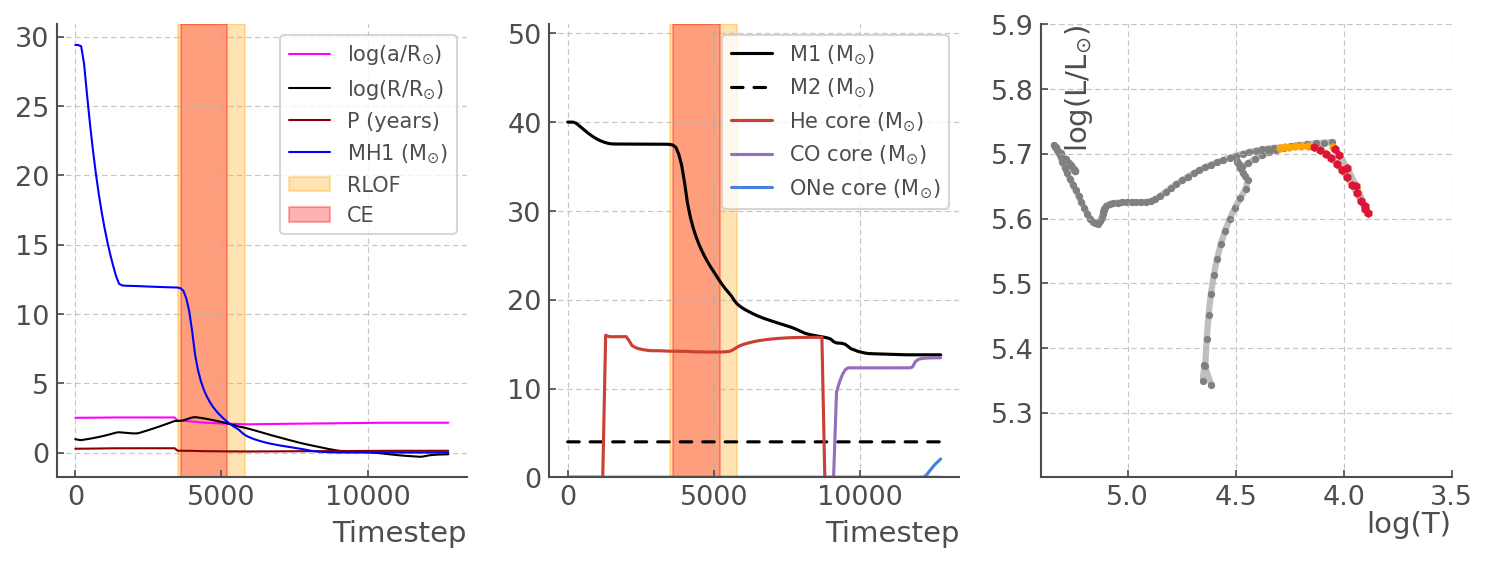

In [86]:
# We want 3 plots in a row - I picked a convenient size for the notebook
# feel free to amend for your own plotting needs. 
f, ax0 = plt.subplots(ncols=3, nrows=1, figsize=(12,4))
# I decided to name each axis in the array to type fewer square brackets - very optional
ax, ax1, ax2 = ax0[0], ax0[1] , ax0[2]


# PLOT 0
# this plot shows the radius and period evolution over the life of the stars
# it also shows the mass as it's interesting to see where most of the mass is lost 
# especially with respect to the stages of mass transfer. 
ax.plot(dummy_df['timestep'], dummy_df['log(a)'], label='log(a/R$_{\odot}$)', 
        color='magenta', lw=1)
ax.plot(dummy_df['timestep'], dummy_df['log(R1)'], label='log(R/R$_{\odot}$)', color='k', lw=1)
ax.plot(dummy_df.timestep, dummy_df.P_bin, label='P (years)', color='darkred', lw=1)
ax.plot(dummy_df['timestep'], dummy_df['MH1'], label='MH1 (M$_{\odot}$)', color='b', lw=1)

# Highlighting the common envelope evolution and RLOF
ax.axvspan(dummy_df[mt_mask].timestep.min(), 
                 dummy_df[mt_mask].timestep.max(), color='orange', 
                 label='RLOF', alpha=0.3)

ax.axvspan(dummy_df[cee_mask].timestep.min(), 
                 dummy_df[cee_mask].timestep.max(), color='red', 
                 label='CE', alpha=0.3)

ax.legend()
ax.set_xlabel('Timestep', loc='right')

# PLOT 1
# this plot shows the evolution of the cores' mass coordinates and the mass of the two companions. 
# Note that when He_core1 == M1 then the value of He_core1 drops to 0. That is because
# when the helium core mass cordinate reaches the outside of the star it's no longer a core... it's
# just a helium star. You could fix the plotting by just plotting M1 as He_core1 beyond that. 
# This plot is useful to know where the mass transfer and CEE occurs with respect to the 
# main sequence and post main sequence evolution. 
ax1.plot(dummy_df['timestep'], dummy_df['M1'], label='M1 (M$_{\odot}$)', color='k')
ax1.plot(dummy_df['timestep'], dummy_df['M2'], label='M2 (M$_{\odot}$)', color='k', ls='--')
ax1.plot(dummy_df['timestep'], dummy_df['He_core1'], label='He core (M$_{\odot}$)')
ax1.plot(dummy_df['timestep'], dummy_df['CO_core1'], label='CO core (M$_{\odot}$)')
ax1.plot(dummy_df['timestep'], dummy_df['ONe_core1'], label='ONe core (M$_{\odot}$)')


# Highlighting the common envelope evolution and RLOF
ax1.axvspan(dummy_df[mt_mask].timestep.min(), 
                 dummy_df[mt_mask].timestep.max(), color='orange', 
                  alpha=0.3)

ax1.axvspan(dummy_df[cee_mask].timestep.min(), 
                dummy_df[cee_mask].timestep.max(), color='red', 
                  alpha=0.3)    

ax1.set_ylim([0,51])
ax1.legend()
ax1.set_xlabel('Timestep', loc='right')


# PLOT2 
# This is just your HR Diagram! I like to plot the evolutionary track as a continuous line and overplot
# in large markers a scatter plot so we can see where each timestep (that recorded the data of the plots 0
# and 1) is - as we can see those timesteps are denser in areas that change more rapidly. 
ax2.plot(dummy_df['log(T1)'], dummy_df['log(L1)'], color='grey', alpha=0.5, lw=3, zorder=0.1)
ax2.scatter(dummy_df['log(T1)'], dummy_df['log(L1)'], color='grey')
# plotting the common envelope evolution time steps in a different colour
ax2.scatter(dummy_df[cee_mask]['log(T1)'], dummy_df[cee_mask]['log(L1)'], 
            zorder=10, color='crimson', marker='h',s=10)
# plotting the stable mass transfer time steps in a different colour
ax2.scatter(dummy_df[mt_mask]['log(T1)'], dummy_df[mt_mask]['log(L1)'], 
            color='orange', marker='h',s=10)

# YOU MIGHT WANT TO ADJUST THESE RANGES FOR OTHER MODELS
ax2.set_ylim([5.2001, 5.9]) 
ax2.set_xlim([5.4, 3.5])
# This is just a mroe convenient location for the labels. Padding will need to change if size changes
ax2.set_ylabel('log(L/L$_{\odot}$)', loc='top', labelpad=-50)
ax2.set_xlabel('log(T)', loc='right', labelpad=-35)


ax2.set_xlabel('log(T)',loc='center',labelpad=0)

In [89]:
# just checking M2 does increase in mass at least a bit.. it's a weird model 
# but if it stayed at 4.0 the whole time it would be worryingly weird
dummy_df.M2.values

array([4.      , 4.      , 4.      , 4.      , 4.      , 4.      ,
       4.      , 4.      , 4.      , 4.      , 4.      , 4.      ,
       4.      , 4.      , 4.      , 4.      , 4.      , 4.      ,
       4.      , 4.      , 4.      , 4.      , 4.      , 4.      ,
       4.      , 4.      , 4.      , 4.      , 4.      , 4.      ,
       4.      , 4.      , 4.      , 4.      , 4.      , 4.000171,
       4.000171, 4.000171, 4.000171, 4.000171, 4.000171, 4.000171,
       4.000171, 4.000171, 4.000171, 4.000171, 4.000171, 4.000171,
       4.000171, 4.000171, 4.000171, 4.000171, 4.000171, 4.000171,
       4.000171, 4.000171, 4.000171, 4.000171, 4.000171, 4.000171,
       4.000171, 4.000171, 4.000171, 4.000171, 4.000171, 4.000171,
       4.000171, 4.000171, 4.000171, 4.000171, 4.000171, 4.000171,
       4.000171, 4.000171, 4.000171, 4.000171, 4.000171, 4.000171,
       4.000171, 4.000171, 4.000171, 4.000171, 4.000171, 4.000171,
       4.000171, 4.000171, 4.000171, 4.000171, 4.000171, 4.000

Okay I did say I picked a weirdo model, apparently this secondary gains very little mass and the mass -> probably because most of the RLOF timesteps are CEE and that leads to mostly mass ejection. 

If you want to look at some "real life" models that came up in publications recently you can check the [SN 2017gci paper](https://ui.adsabs.harvard.edu/abs/2021MNRAS.504L..51S/abstract) (SLSN-I), the [NGC 1851-BH1 paper](https://ui.adsabs.harvard.edu/abs/2022MNRAS.511L..77S/abstract) (quiescent black hole binary.. or not), the [VFTS 243 paper](https://ui.adsabs.harvard.edu/abs/2022arXiv220802258S/abstract) (quiescent black hole binary, for real). 



## Preserve your results with pickle!
Finally let us save our `Eve` object with all of our extra columns and the new table so that we don't have to rerun all this when we continue our analysis tomorrow. 

In [91]:
import pickle

file = open('myeve.pkl', 'wb') # open a file, where you ant to store the data
pickle.dump(eve, file) # dump information to that file
file.close() # close the file

And if you want to open your object again you can do:

In [92]:
file = open('myeve.pkl', 'rb')
eve_again = pickle.load(file)
file.close()

In [93]:
eve_again.SUMMARY_best

M1_ZAMS  M2_ZAMS    P_ZAMS  lifetime_MS  MT_bool  CEE_bool  \
MODEL_ID                                                               
159747       40.0  25.1189  0.006890    4660114.0        1         0   
159748       40.0  25.1189  0.010920    4585610.0        1         0   
159750       40.0  25.1189  0.027429    4454813.0        1         1   
159751       40.0  25.1189  0.043472    4454813.0        1         1   
159752       40.0  25.1189  0.068898    4454813.0        1         1   
...           ...      ...       ...          ...      ...       ...   
158713       40.0  12.5893  0.017306    4454813.0        1         1   
158714       40.0  12.5893  0.027429    4454813.0        1         1   
158715       40.0  12.5893  0.043472    4454813.0        1         1   
158716       40.0  12.5893  0.068898    4454813.0        1         1   
158717       40.0  12.5893  0.109195    4454813.0        1         1   

            AGE_end    M1_end    M2_end          P_end  modelimf  mixedimf  \
MODEL_ID                                                                     
159747    5618206.0  10.53407  46.20547  0.1730591E-01  0.000821  0.000000   
159748    5488492.0  11.03129  45.24818  0.2517517E-01  0.001601  0.000000   
159750    5429943.0  11.71055  27.49449  0.2470479E-01  0.002769  0.000000   
159751    5427022.0  12.19142  27.17696  0.3985545E-01  0.003708  0.013488   
159752    5427732.0  12.82921  26.93096  0.6465621E-01  0.005269  0.296793   
...             ...       ...       ...            ...       ...       ...   
158713    5433841.0  11.19408  14.40241  0.1290614E-01  0.003516  0.116958   
158714    5430873.0  11.60518  13.67144  0.2227098E-01  0.008946  0.376418   
158715    5427329.0  12.07276  13.54084  0.3655669E-01  0.023674  0.476126   
158716    5427097.0  12.68744  13.43443  0.6022988E-01  0.104141  0.604571   
158717    5430072.0  13.46907  13.34467  0.1000394E+00  0.275734  0.529478   

          type      Nimf  
MODEL_ID                  
159747       2  0.000821  
159748       2  0.001601  
159750       2  0.002769  
159751       2  0.017196  
159752       2  0.302062  
...        ...       ...  
158713       2  0.120474  
158714       2  0.385365  
158715       2  0.499800  
158716       2  0.708711  
158717       2  0.805212  

[116 rows x 14 columns]

And as you can see it contains the new attributes that we created like `SUMMARY_best`! 

---

## If you have a question or a complain...
I've said it already but it is worth repeating. Let me know if you have questions or issues!
You can start an issue on the [hoki](https://github.com/HeloiseS/hoki) github or send me an e-mail (hfstevance@gmail.com).

Now go and find your stars!